<a href="https://colab.research.google.com/github/cchen744/uhi-extreme-heat-response/blob/main/notebooks/02_uhi_extreme_heat_response.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In notebook 01, we have finished data preprocessing and output cleaned dataset containing urban temp, rural ring temp, as well as extreme heat.
In this notebook, we will use Philadelphia, Los Angeles, Phoenix, Houston, and Chicago as sample cities to test whether extreme heat would contribute to the change in UHI.


In [1]:
!git init
!git remote add origin https://github.com/cchen744/uhi-extreme-heat-response.git
!git pull origin main --allow-unrelated-histories
!git status

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 153, done.
remote: Counting objects: 100% (153/153), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 153 (delta 66), reused 136 (delta 58), pack-reused 0 (from 0)
Receiving objects: 100% (153/153), 1.04 MiB | 7.44 MiB/s, done.
Resolving deltas: 100% (66/66), done.
From https://github.com/cchen744/uhi-extreme-heat-response
 * branch            main       -> FETCH_HEAD
 * [new branch]      main       -> origin/ma

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The following block of code will use a set of extreme heat definitions to examine extreme weather frequency on each city, in general we have extreme heat definition of:
- Percentile: 85, 90, 92.5, 95
- Absolute Threshold (Celsius): 22, 24, 26, 30, 35


In [3]:
for filename in os.listdir('/content/data/cities'):
  current_df = pd.read_csv('/content/data/cities/'+filename)
  print('\n'+filename.split('_')[0])

  current_df['date'] = current_df['date'].astype(str)
  current_df['date'] = pd.to_datetime(current_df['date'], errors='coerce', format='mixed')

  current_df.dropna(subset=['date'], inplace=True)

  # Convert 'LST_urb' to numeric, coercing errors to NaN
  # This step is crucial because np.percentile expects numeric data.
  current_df['LST_urb'] = pd.to_numeric(current_df['LST_urb'], errors='coerce')

  # Drop rows where 'LST_urb' is NaN, as np.percentile needs valid numbers.
  # Alternatively, NaNs could be handled by imputation or other methods,
  # but for percentile calculation, dropping is a common approach if missing values are few.
  current_df.dropna(subset=['LST_urb'], inplace=True)

  sorted_current_df = current_df.sort_values("date").copy()

  # 1) percentile only (no consecutive)
  for p in [85, 90, 92.5, 95]:
    thr = np.percentile(sorted_current_df["LST_urb"], p)
    n = (sorted_current_df["LST_urb"] >= thr).sum()
    print("percentile", p, "days:", n)

  # 2) absolute thresholds
  for t in [22, 24, 26, 30, 35]:
    n = (sorted_current_df["LST_urb"] >= t).sum()
    print("abs >=", t, "C days:", n)



Nashville
percentile 85 days: 217
percentile 90 days: 145
percentile 92.5 days: 109
percentile 95 days: 73
abs >= 22 C days: 77
abs >= 24 C days: 13
abs >= 26 C days: 0
abs >= 30 C days: 0
abs >= 35 C days: 0

Phoenix
percentile 85 days: 253
percentile 90 days: 169
percentile 92.5 days: 127
percentile 95 days: 85
abs >= 22 C days: 548
abs >= 24 C days: 418
abs >= 26 C days: 259
abs >= 30 C days: 34
abs >= 35 C days: 16

Los Angeles
percentile 85 days: 300
percentile 90 days: 200
percentile 92.5 days: 150
percentile 95 days: 100
abs >= 22 C days: 26
abs >= 24 C days: 9
abs >= 26 C days: 5
abs >= 30 C days: 4
abs >= 35 C days: 4

Chicago
percentile 85 days: 10
percentile 90 days: 7
percentile 92.5 days: 5
percentile 95 days: 4
abs >= 22 C days: 0
abs >= 24 C days: 0
abs >= 26 C days: 0
abs >= 30 C days: 0
abs >= 35 C days: 0

Philadelphia
percentile 85 days: 272
percentile 90 days: 182
percentile 92.5 days: 136
percentile 95 days: 91
abs >= 22 C days: 35
abs >= 24 C days: 7
abs >= 26 C 

**Interpretation**

1. **Chicago,IL**: Under percentile-based definitions, Chicago yields too few extreme heat days to support a distributional comparison of SUHI. *So now Chicago will be excluded due to insufficient extreme-day samples*
2. **Phoenix,AZ**: Phoenix's extreme heat definition is statistically stable under multiple operationalizzations
3. **Houston,TX**: definition under percentile is applicable, while definition under high absolute threshold performs down.

**Thus, we will take Phoenix and Houston as response test sample cities, while take Chicago as the baseline city**

## SUHI & Extreme Heat Correlation Check

By using boxplot, we expect to see if the under extreme heat, the distribution of SUHI would be different.

In [19]:
def plot_uhi_extreme_test(path:str):
# Boxplot - Phoenix
  city_name = path.split('/')[-1].split('_')[0]
  print('\nDisplay of ',city_name)
  df = pd.read_csv('/content/data/cities/Phoenix_daily_suhi.csv')

  suhi_non = df.loc[df["is_extreme"] == 0, "SUHI"]
  suhi_ext = df.loc[df["is_extreme"] == 1, "SUHI"]

  plt.figure(figsize=(6,4))
  plt.boxplot(
      [suhi_non, suhi_ext],
      labels=["Non-extreme", "Extreme"],
      showfliers=True
  )
  plt.ylabel("SUHI (°C)")
  plt.title(f"{city_name} - SUHI Distribution: Extreme vs Non-extreme Days")
  plt.show()

  mean_ext = suhi_ext.mean()
  mean_non = suhi_non.mean()
  delta = mean_ext - mean_non
  print("Mean of Extreme Days:", mean_ext)
  print("Mean of Non-Extreme Days:", mean_non)

  # Mann–Whitney test: check statistical significance
  u, p = mannwhitneyu(
      suhi_ext,
      suhi_non,
      alternative="greater"
  )

  print("Mann–Whitney test u, p:", float(u), float(p))



Display of  Nashville


/tmp/ipython-input-1853566649.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


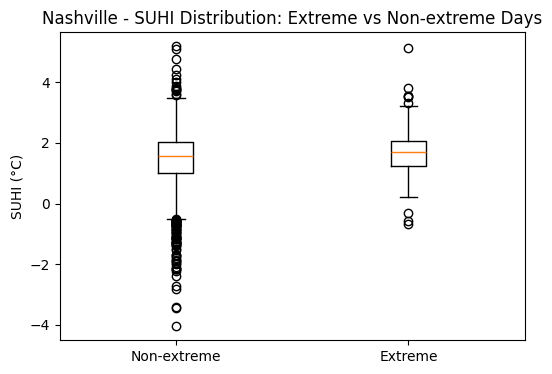

Mean of Extreme Days: 1.6880631191645132
Mean of Non-Extreme Days: 1.4428379244753669
Mann–Whitney test u, p: 222791.0 0.0016852276332208534

Display of  Phoenix


/tmp/ipython-input-1853566649.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


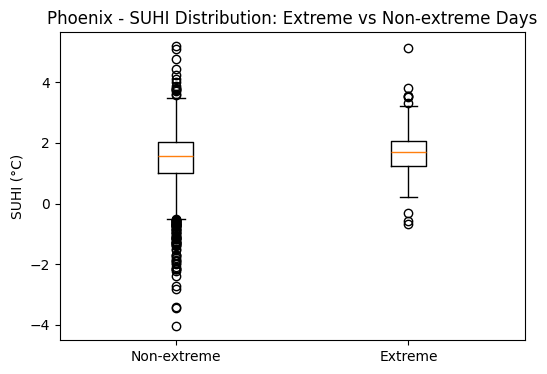

Mean of Extreme Days: 1.6880631191645132
Mean of Non-Extreme Days: 1.4428379244753669
Mann–Whitney test u, p: 222791.0 0.0016852276332208534

Display of  Los Angeles


/tmp/ipython-input-1853566649.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


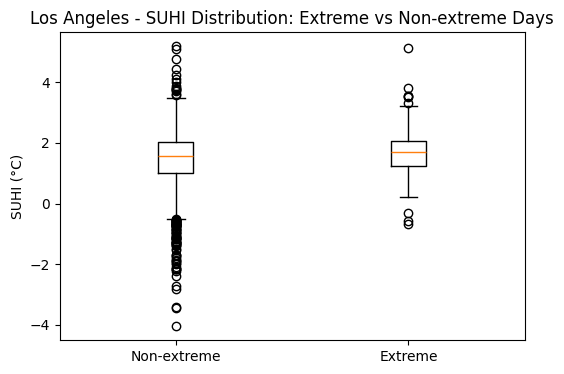

Mean of Extreme Days: 1.6880631191645132
Mean of Non-Extreme Days: 1.4428379244753669
Mann–Whitney test u, p: 222791.0 0.0016852276332208534

Display of  Chicago


/tmp/ipython-input-1853566649.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


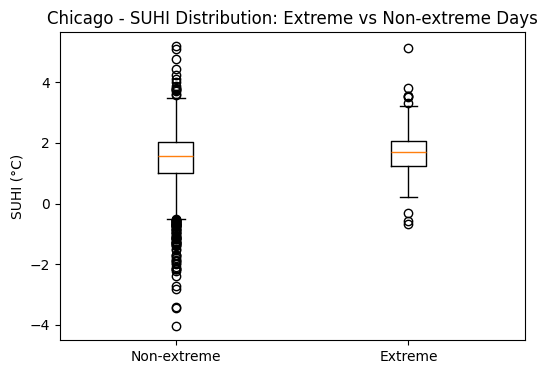

Mean of Extreme Days: 1.6880631191645132
Mean of Non-Extreme Days: 1.4428379244753669
Mann–Whitney test u, p: 222791.0 0.0016852276332208534

Display of  Philadelphia


/tmp/ipython-input-1853566649.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


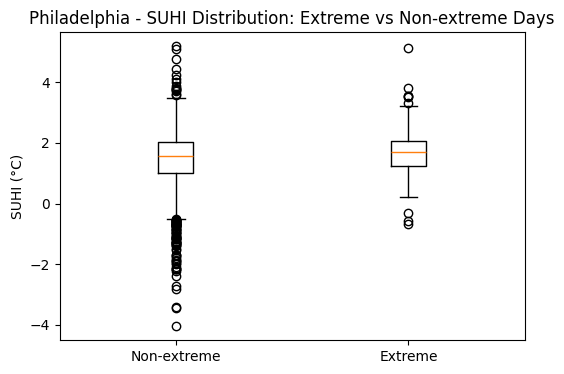

Mean of Extreme Days: 1.6880631191645132
Mean of Non-Extreme Days: 1.4428379244753669
Mann–Whitney test u, p: 222791.0 0.0016852276332208534

Display of  Houston


/tmp/ipython-input-1853566649.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


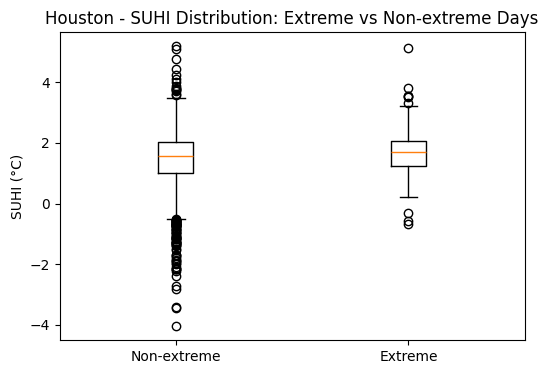

Mean of Extreme Days: 1.6880631191645132
Mean of Non-Extreme Days: 1.4428379244753669
Mann–Whitney test u, p: 222791.0 0.0016852276332208534


In [20]:
for path in os.listdir('/content/data/cities'):
  plot_uhi_extreme_test('/content/data/cities/'+path)

Early Findings